In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sasmodels.core import load_model
from sasmodels.data import Data1D
from sasmodels.bumps_model import Model, Experiment
from sasmodels.mixture import *

import bumps
from bumps.fitters import fit

import argparse, glob, os, shutil, pdb, time, datetime, json

In [ ]:
def load_data_from_file(fname):
    saxs = np.load(fname)
    dIq = 0.05 * saxs["Iq"]
    data = Data1D(x=saxs["q"], y=saxs["Iq"], dy=dIq) 

    return data


In [4]:
def setup_model():
    hardsphere = load_model("hardsphere")
    sphere = load_model("sphere")
    capped_cylinder = load_model("capped_cylinder")

    model_info = make_mixture_info([sphere.info, capped_cylinder.info], operation="+")
    model = MixtureModel(model_info, [sphere, capped_cylinder])
    bumps_model = Model(model=model)
    param_names = model.info.parameters.call_parameters
    # print("Parameter names:", param_names)
    
    bumps_model.scale.range(1e-15, 1e-5)
    bumps_model.A_scale.range(0.0, 1.0)
    bumps_model.A_scale.value = 0.5
    bumps_model.B_scale.fixed = True
    bumps_model.B_scale.value = 1-bumps_model.A_scale
    bumps_model.background.fixed = True 
    bumps_model.background.value = 0.0

    bumps_model.A_sld.fixed = True
    bumps_model.A_sld.value = 124.823 
    bumps_model.A_sld_solvent.fixed = True
    bumps_model.A_sld_solvent.value = 9.469

    bumps_model.B_sld.fixed = True
    bumps_model.B_sld.value = 124.823 
    bumps_model.B_sld_solvent.fixed = True
    bumps_model.B_sld_solvent.value = 9.469

    # Parameter for spheres (with A_)
    bumps_model.A_radius.range(2.0, 500.0)
    
    # Parameters for cylinder-capped (with B_)
    bumps_model.B_length.range(2.0, 500.0)
    bumps_model.B_radius_cap.range(2.0, 500.0)
    bumps_model.B_radius.range(1.0, 500.0)

    return model, bumps_model

In [5]:
NUM_STEPS = 100

def fit_file_model(fname):
    start = time.time()
    data = load_data_from_file(fname)
    # print('Fitting the following sample : \n', fname)
    sas_model, bumps_model = setup_model()

    cutoff = 1e-3  # low precision cutoff
    experiment = Experiment(data=data, model=bumps_model, cutoff=cutoff)
    problem = bumps.fitproblem.FitProblem(experiment)
    results = bumps.fitters.fit(problem, method='dream', verbose=False)
    # print("final chisq", problem.chisq_str())
    # print('Final fitting parameters for : ', fname)
    # print('Parameter Name\tFitted value')
    # for key, param in bumps_model.parameters().items():
    #     if not param.fixed:
    #         print(key, '\t', '%.2e'%param.value)

    fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    axs[0].scatter(data.x, data.y, label='True')
    axs[0].plot(data.x, problem.fitness.theory(), label='predicted', color='tab:orange')

    axs[0].set_xlabel('q')
    axs[0].set_ylabel('I(q)')
    axs[0].legend()
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')

    # plot residuals
    residuals = problem.fitness.residuals()
    axs[1].scatter(data.x, residuals)
    axs[1].set_title('Chisq : %.2e'%problem.chisq())
    axs[1].set_xlabel('q')
    axs[1].set_ylabel('residuals')
    axs[1].set_xscale('log')
    plt.tight_layout()
    end = time.time()
    time_str =  str(datetime.timedelta(seconds=end-start)) 
    print('Total fitting time : %s'%(time_str))
    plt.show()

    return data, sas_model, problem, bumps_model

# steps: 167, # draws: 10020
Total fitting time : 0:02:15.597217


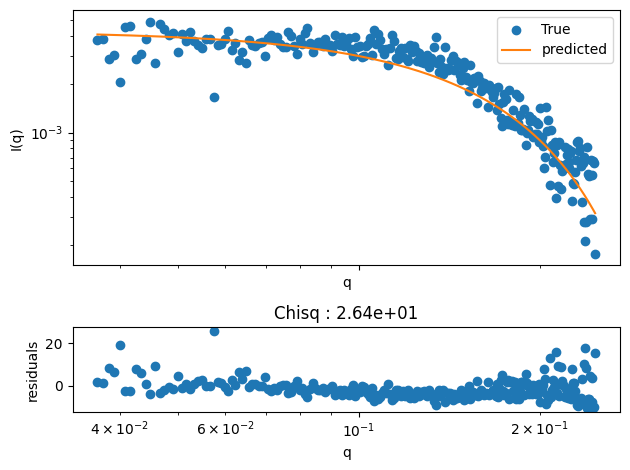

Current best error: 2.64e+01
# steps: 167, # draws: 10020
Total fitting time : 0:02:52.458249


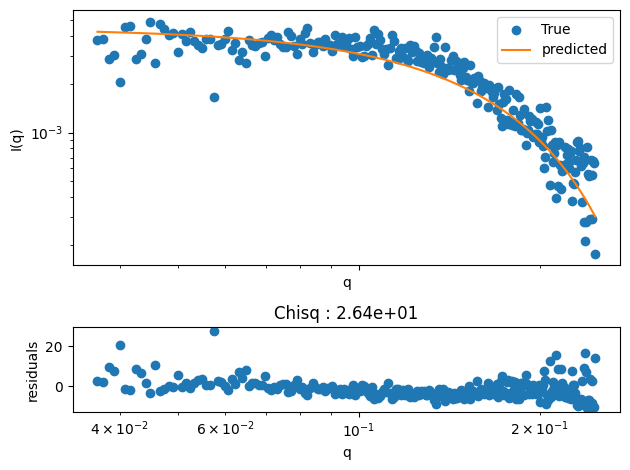

Current best error: 2.64e+01
# steps: 167, # draws: 10020
Total fitting time : 0:02:16.383478


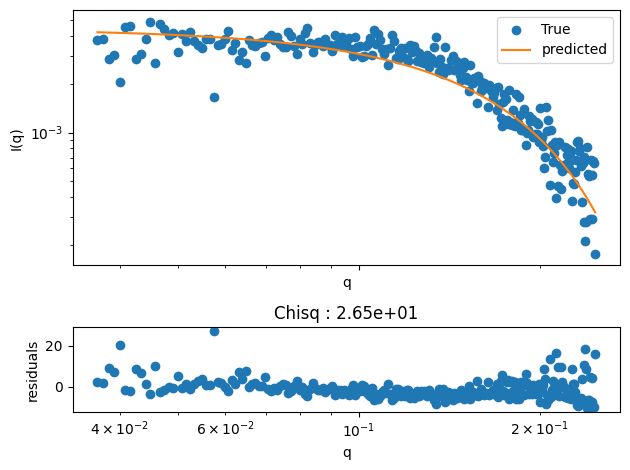

# steps: 167, # draws: 10020
Total fitting time : 0:02:40.807036


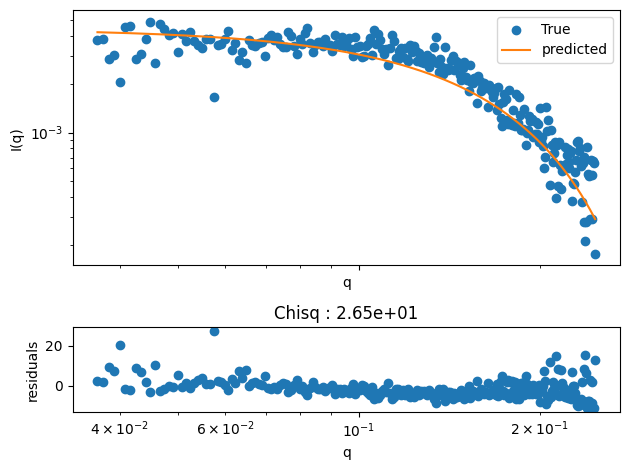

# steps: 167, # draws: 10020
Total fitting time : 0:03:01.299820


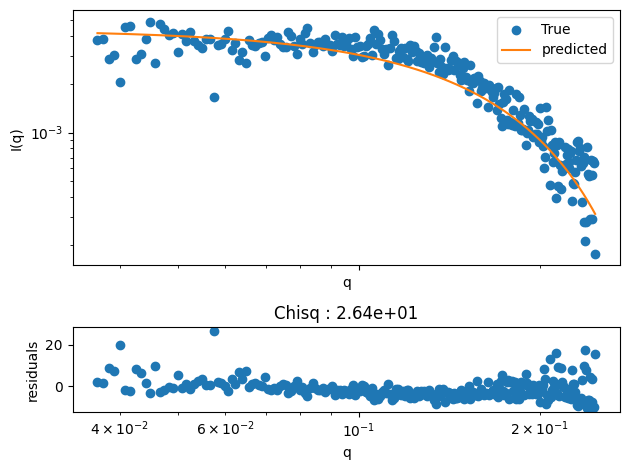

Current best error: 2.64e+01
# steps: 167, # draws: 10020
Total fitting time : 0:02:24.467622


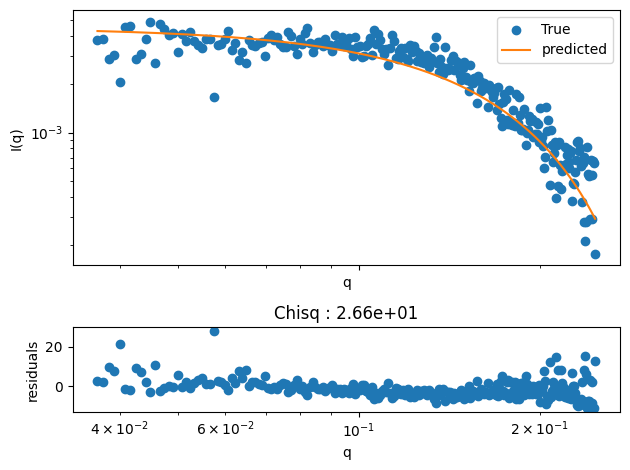

# steps: 167, # draws: 10020
Total fitting time : 0:02:12.410083


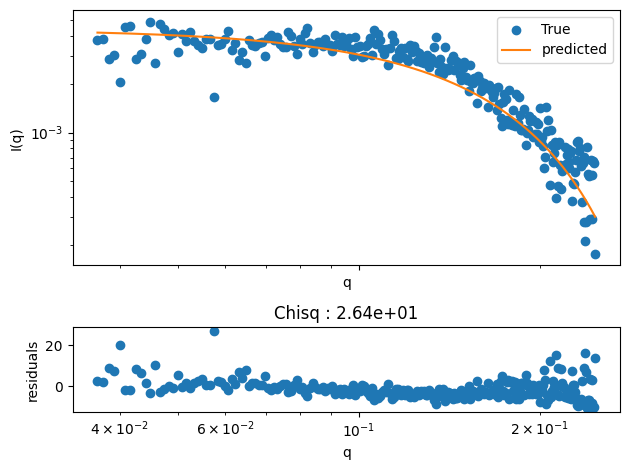

# steps: 167, # draws: 10020
Total fitting time : 0:01:43.875171


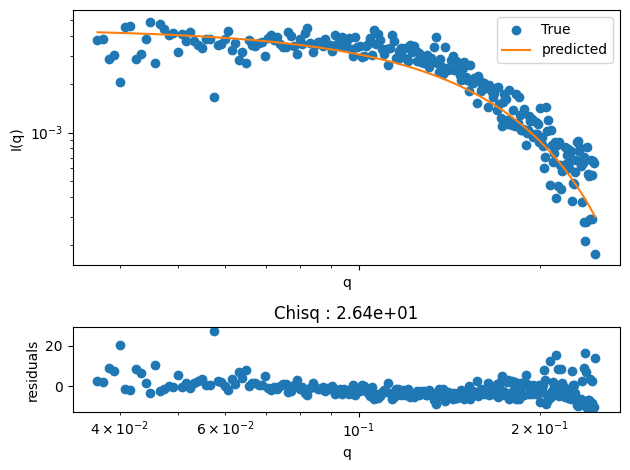

# steps: 167, # draws: 10020
Total fitting time : 0:02:16.720678


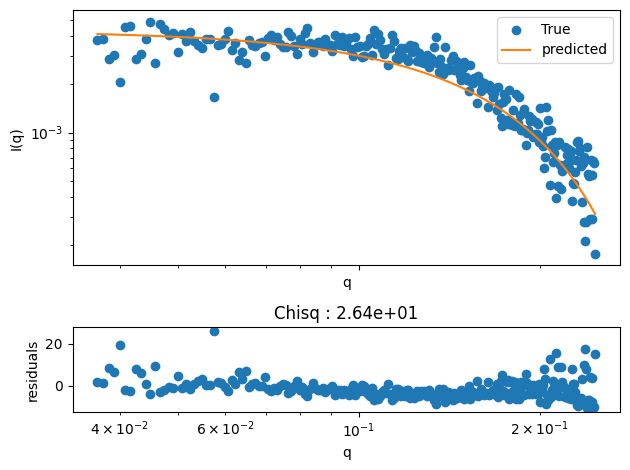

# steps: 167, # draws: 10020
Total fitting time : 0:02:24.507365


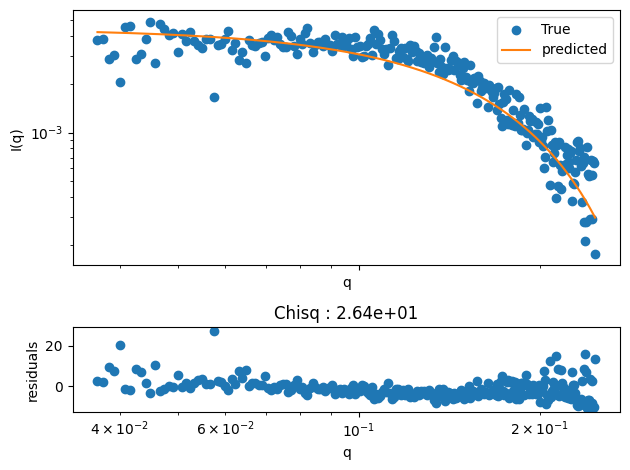

In [6]:
ind = 1
fname = "./merged_data/%d.npz"%(ind)
for i in range(10):
    data, sas_model, problem, bumps_model = fit_file_model(fname)
    if i==0:
        best_params = bumps_model.parameters()
        best_error = problem.chisq()
        print("Current best error: %.2e"%best_error)
    else:
        if problem.chisq()<best_error:
            best_params = bumps_model.parameters()
            best_error = problem.chisq()
            print("Current best error: %.2e"%best_error)

In [9]:
import re 
match = re.search(r'/(\d+)\.npz$', fname)
number = int(match.group(1))
print(number)

2


In [7]:
# Save parameter values
ind = 2
fname = "./merged_data/%d.npz"%(ind)
params_to_json = {}
for name, param in best_params.items():
    value = param.value
    if isinstance(value, bumps.parameter.Operator):
        value = value.value 
    params_to_json[name] = value
        
with open("./fits/%d.json"%ind, "w") as f:
    json.dump(params_to_json, f)
